In [86]:
# need to install below to enable some features in plot_partial_dependence
%pip install scikit-learn==0.24

Note: you may need to restart the kernel to use updated packages.


## Set up

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter
from sklearn.metrics import mean_squared_error


In [2]:
# ==================== Define functions ====================

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result





In [3]:
# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')





[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators


In [4]:
AllData.head()

,x,y,Bio_01,Bio_02,Bio_03,Bio_04,Bio_05,Bio_06,Bio_07,Bio_08,...,Bio_18,Bio_19,DG_000_014bt_dens,Elv,Pigs,Rice,UR,VD,Adjusted_Pop_Count_2015,FOI
0,13717.407892,5959.817018,-3.533434,14.667511,24.080265,1743.920532,25.633081,-35.277302,60.910385,16.902985,...,280.531250,15.885687,0.096940,324.425049,0.086128,8.804602,1,0.285594,27.158179,0.163308
1,13722.407892,5959.817018,-3.515078,14.740572,24.211077,1737.165649,25.591284,-35.291855,60.883141,16.848240,...,281.375214,16.805054,0.106271,339.754822,0.088851,0.000000,1,0.282270,46.891705,0.164386
2,13727.407892,5959.817018,-3.505363,14.655778,24.143412,1735.075928,25.490971,-35.211075,60.702045,16.827511,...,281.311707,16.730371,0.110514,328.791656,0.055739,0.000000,1,0.296362,29.772409,0.165014
3,13747.407892,5959.817018,-3.203640,14.476027,23.880190,1734.776611,25.709829,-34.909279,60.619106,17.131897,...,281.548340,16.541552,2.518467,281.210266,0.125748,5.982415,1,0.187785,10.536764,0.163172
4,13757.407892,5959.817018,-3.142176,15.133987,24.704348,1729.607788,26.100000,-35.160149,61.260151,17.148170,...,282.543854,16.618938,2.763509,273.763184,0.072534,0.000000,1,0.313313,13.470044,0.163207


In [5]:
# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')





[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index


In [6]:
# ==================== Create Train-Validate-Test dataset ====================
# ==================== SJ: Thinning the dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Train_Non_NA = Train_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Validate_Non_NA = Validate_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Test_Non_NA = Test_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 1%
EndemicDF_Non_NA = EndemicDF_Non_NA.sample(frac = 0.01, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)

# ----- Find max_ft for randomforest regression = numft / 3 (default) -----
num_ft = np.floor(X_train.shape[1]/3)
if (num_ft != X_train.shape[1]/3):
    num_ft = num_ft + 1
num_ft = int(num_ft)


[Preprocessing] Total Training containing NA: 0 / 488914 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 89152 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 123240 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


## Random Forest


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import validation_curve


### Model Building

- `n_estimators` means the number of trees. 
- `max_features` tells each tree how many features to check when looking for the best split to make. This is an important feature that differentiates RF from simple bagging. Having random selection of features for each tree reduces the correlation between trees, thus reducing variance in predictions.  
- `max_depth` is the how many splits deep you want each tree to go. If the trees are shallow, we need to compensate with more trees. 
- `min_samples_leaf` tells each tree to stop splitting if the number of nodes in any branch is already the minimum we set. Reducing the `min_samples_leaf` helps reduce correlation between trees, but it could increase bias as each tree now has less data to work with. 

In [8]:
m_name = 'RF'

In [13]:
# ============== Hyperparameter Tuning with RF

# most important params to tune: n_estimators, max_features

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, verbose=1, 
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [24]:
# Print the best parameters and lowest MSE
bestp = rf_random.best_params_
print("Best parameters found: ", bestp)

Best parameters found:  {'n_estimators': 800, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}


In [9]:
# for reference
bestp = {'n_estimators': 800, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

In [15]:
# save best parameters to csv
bestp_pd = pd.DataFrame(list(bestp.items()), columns = ['Parameters','Value'])
filename_bestp = 'Bestp_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
bestp_pd.to_csv(Savepath + filename_bestp, sep='\t', encoding='utf-8')


In [10]:
# ============== Refit RF with the optimal params

regr = RandomForestRegressor(n_estimators = bestp['n_estimators'], 
                             min_samples_leaf= bestp['min_samples_leaf'], 
                             max_features= bestp['max_features'], 
                             max_depth= bestp['max_depth'],random_state = 123)

In [11]:
start_time = time.time()
regr.fit(X_train, Y_train)
end_time = time.time()
print('[Training] Finish training')
training_time = round(end_time - start_time, 5) # seconds
print('Training Time: ' + str(training_time) + ' seconds')

yhat = regr.predict(X_test)

[Training] Finish training
Training Time: 176.80395 seconds


In [20]:
# ============== Save the model, note that the model is VERY big

filename_model = Savepath + 'ModelRF_' + '.model'
print('[Saving] Save training model')
pickle.dump(regr, open(filename_model, 'wb'))

[Saving] Save training model


In [ ]:
# You can load the model by the following way

# filename_model = Savepath + 'ModelRF_' + '.model'
# regr = pickle.load(open(filename_model, 'rb'))

### Evaluate model performance

In [20]:
# ============== 1. MSE
mse_train = mean_squared_error(Y_test, yhat)
mse_test = mean_squared_error(Y_test, yhat)
print("train MSE: %f" % (mse_train))
print("test MSE: %f" % (mse_test))

train MSE: 0.001762
test MSE: 0.001762


This is a rather impressive result. 

In [21]:
# Export csv of MSE
print('[Saving] Save MSE evaluation')        
Result_pd = pd.DataFrame(data = {'mse_train':[mse_train], 'mse_test':[mse_test], 'time_train':[training_time]})   
filename_mse = 'MSE_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Result_pd.to_csv(Savepath + filename_mse, sep='\t', encoding='utf-8')

[Saving] Save MSE evaluation


In [18]:
# ============== 2. MSE on train/validation
rf = RandomForestRegressor(n_estimators = 1, 
                             min_samples_leaf= 1, 
                             max_features= 'sqrt', 
                             max_depth= 40,random_state = 123)
mse_train = []
mse_validate = []
list_nb_trees = np.arange(10,791,30)

for tree in list_nb_trees:
    rf.n_estimators = tree
    rf.fit(X_train, Y_train)
    y_train_predicted = rf.predict(X_train)
    y_validate_predicted = rf.predict(X_validate)
    mse_train.append(mean_squared_error(Y_train, y_train_predicted))
    mse_validate.append(mean_squared_error(Y_validate, y_validate_predicted))
    #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    

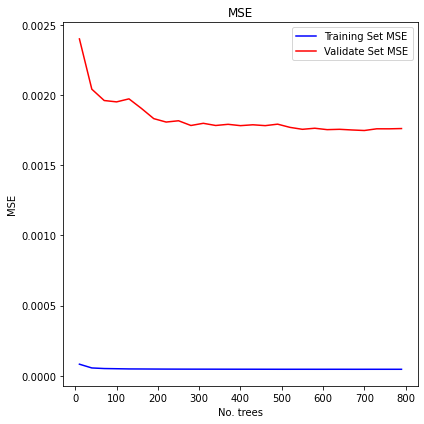

In [19]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Training vs Validation set MSE \n Random Forest')
plt.plot(list_nb_trees, mse_train, 'b-',
         label='Training Set MSE')
plt.plot(list_nb_trees, mse_validate, 'r-',
         label='Validation Set MSE')
plt.legend(loc='upper right')
plt.xlabel('No. trees')
plt.ylabel('MSE')
fig.tight_layout()
plt.show()

# Save MSE plot 
print('[Saving] Save MSE plot')
filename_mse_plot = 'MSE' + m_name + '_'+ Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_mse_plot)

The inventor of Random Forest, Breiman, said that RF does not overfit. (https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm) However, it does. We make the diagnosis based on the error plot above: if the validation MSE picked up after increasing the number of tress, it is a sign of overfitting. 

RF is based on bagging, and bagging is not as good as boosting when it comes to reduce overfitting. Boosting does it by a different way of aggregating trees (ie. build trees sequentially, rather than simultaneously like RF, and also in boosting we use learning rate). 

In [ ]:
# ============== 3. validation curve

In [17]:
list_nb_trees = np.arange(10,791,30)
train_scores, valid_scores = validation_curve(regr, X_train, Y_train, 
                                             'n_estimators', #param to vary
                                             list_nb_trees,  #values of param to vary
                                             cv = 3)

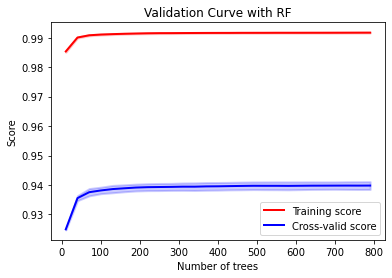

In [23]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"Number of trees")
plt.ylabel("Score")
lw = 2
plt.plot(list_nb_trees, train_scores_mean, label="Training score",
             color="red", lw=lw)
plt.fill_between(list_nb_trees, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.plot(list_nb_trees, valid_scores_mean, label="Cross-valid score",
             color="blue", lw=lw)
plt.fill_between(list_nb_trees, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="blue", lw=lw)
plt.legend(loc="best")
plt.show()

We can also use the built-in diagnostic tool of scikit-learn to check the model. The validation curve shows the training and cross-validation scores as we increase the number of the trees in the model. When we only use very few trees, both scores are low, suggesting underfitting. As we increase the number of trees, the cross-validation scores did not drop, suggesting that we did not overfit.

Note that this is using the training data only. 

### Model output

[Saving] Save variable importance ranking plot
[Saving] Save variable importance ranking


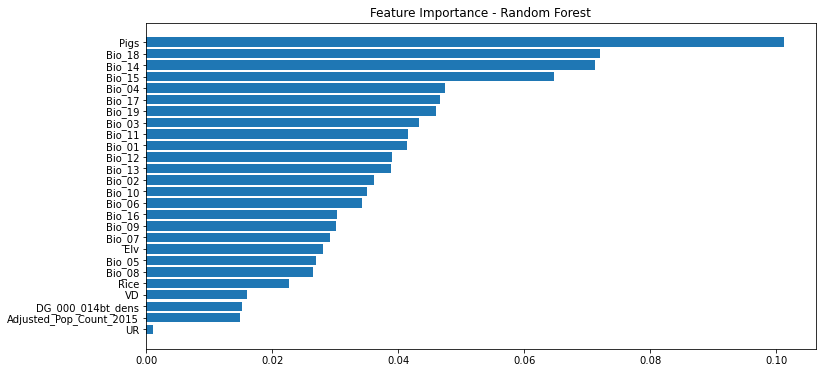

In [12]:
# ============== 1. get feature importances

# feature importance
feature_importance = regr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance - Random Forest')

# Save feature importance and plot 
print('[Saving] Save variable importance ranking plot')
filename_varimp_plot = 'Varimp' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_varimp_plot)

print('[Saving] Save variable importance ranking')
data = {'Name': X_endemic.columns, 'Importance': feature_importance}
importance_df = pd.DataFrame(data)
importance_df["Std"] = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
filename_varimp = 'Varimp' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
importance_df.to_csv(Savepath + filename_varimp, sep='\t', encoding='utf-8')



[Saving] Save cumulative variable importances


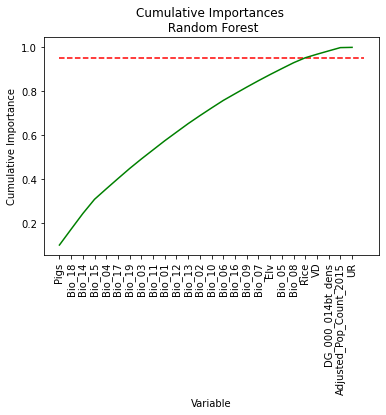

In [74]:
# Cumulative importances
sorted_importances = sorted(feature_importance[sorted_idx],reverse = True)
sorted_features = np.array(X_test.columns)[sorted_idx][::-1] 
x_values = list(range(len(feature_importance)))
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances \n Random Forest')

# Save cumulative importance and plot 
print('[Saving] Save cumulative variable importances')
filename_cum_plot = 'Cum_Varimp' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_cum_plot)



Checking the cumulative importances by feature is usually a good way to do feature selection: it helps us to visualize if any feature greatly increases the importance, indicated by 'kinks' in the line. However, in this case, it doesn't help much. Top features are not particularly more important than others. 

In [13]:
# list of top 10 features based on permutation importance
top10 = np.flip(np.array(X_train.columns)[sorted_idx])[:10]
top10

array(['Pigs', 'Bio_18', 'Bio_14', 'Bio_15', 'Bio_04', 'Bio_17', 'Bio_19',
       'Bio_03', 'Bio_11', 'Bio_01'], dtype=object)

It is also possible to calcualate the permutation importance of the model. Some posts (https://explained.ai/rf-importance/) mentioned that permutation importance should be adopted for robustness. But beware that it is very computationally expensive. 

The difference between an impurity-based feature importance and permutation-based feature importance can be seen here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html. This is also discussed in the notebook for Gradient Boosting and XGBoost. 

An additional note on interpreting the feature importance is that we need to be aware of the correlated features. In other words, features with high importance are most likely really important, but features with low importance are not necessarily not important. See discussion of this in XGBoost.

Due to stochasticity of the algorithm, variable importance will change with each model fitting. 

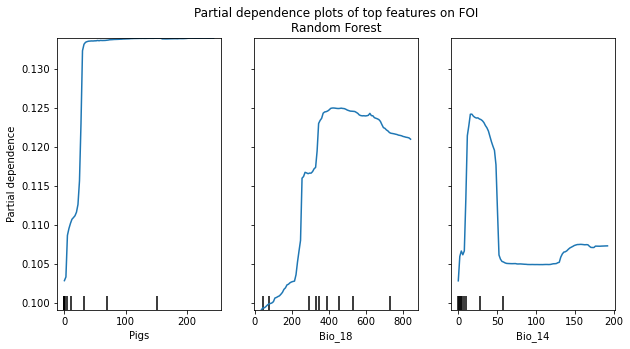

In [20]:
# ============== 2. get dependence plots
# Partial dependence plots
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title( 'Partial dependence plots of top features on FOI\nRandom Forest')
display2 = plot_partial_dependence(regr,X_test, top10[:3],ax = ax)


In [21]:
# Save partial dependence plots
print('[Saving] Save partial dependence plots')
filename_pd_plot = 'PDP' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
ax.figure.savefig(Savepath + filename_pd_plot)

[Saving] Save partial dependence plots


Partial dependence plots is a better way of visualizing the marginal effect of variables on the outcome. See Gradient Boosting notebook for more explanations on this topic. 

Text(0.5, 1.0, 'Partial dependence with individual conditional expectation\n of top features on FOI - Random Forest')

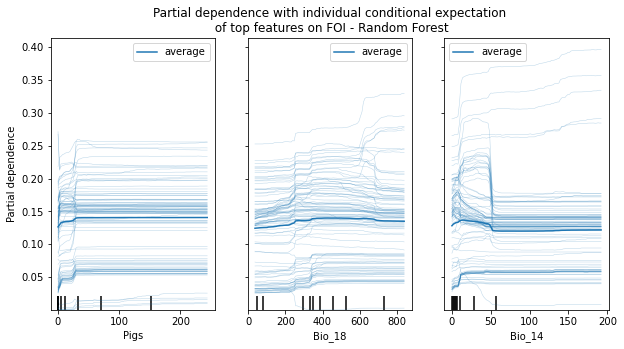

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
display3 = plot_partial_dependence(regr,X_test, top10[:3],ax = ax, kind = 'both', subsample = 100)

ax.set_title( 'Partial dependence with individual conditional expectation\n of top features on FOI - Random Forest')


In [23]:
# Save ICE plots 
print('[Saving] Save individual conditional expectation plots')
filename_ice_plot = 'ICE_RF_' + Typemodel + '_' + str(resolution_grid) + '.png'
ax.figure.savefig(Savepath + filename_ice_plot)

[Saving] Save individual conditional expectation plots


### Model prediction

The problem of constructing prediction intervals for random forest predictions has been addressed in several papers:

- Zhang, Haozhe, Joshua Zimmerman, Dan Nettleton, and Daniel J. Nordman. "Random Forest Prediction Intervals." The American Statistician,2019. The R function 'rfinterval' was based on this paper. 

- Susan Athey, Julie Tibshirani, Stefan Wager. 'Generalized Random Forests'. Annals of Statistics, 2018. 

- S. Wager, T. Hastie, B. Efron. “Confidence Intervals for Random Forests: The Jackknife and the Infinitesimal Jackknife”, Journal of Machine Learning Research vol. 15, pp. 1625-1651, 2014. The Python package 'forestci' and the R package 'grf' was developed based on this paper.

#### Method 1: forestci

We use 'forestci' below. This method calculates the variance of the predicted values from the RandomForest objects, which can be used to obtain the confidence interval. The underlying assumption is that the predicted Y follows a normal distribution. 

In [24]:
pip install forestci

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install duecredit 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# revert to this version to enable installation of forestci

In [30]:
pip install scikit-learn==0.23.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
import forestci as fci

/Users/jiesun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# output plot and save 
def plotci_1(Y_test, yhat, ylow, yup):
    # dataframe
    dat = np.concatenate((Y_test.reshape(-1,1), 
                          yhat.reshape(-1,1), 
                          ylow.reshape(-1,1), 
                          yup.reshape(-1,1)), axis = 1)
    dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])

    # sort the dataframe for plotting
    dat2 = dat.sort_values('y')

    # plot1
    fig, ax = plt.subplots(figsize = (15,10))
    plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
    plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
    ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
    ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
    ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
    plt.xlabel('Actual Y')
    plt.ylabel('Predicted Y')
    plt.title('95% prediction interval of Y versus the original Y')
    plt.legend()

    # plot2
    fig, ax = plt.subplots(figsize = (15,10))
    plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
    plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
    # ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
    # ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
    # ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
    plt.xlabel('Actual Y')
    plt.ylabel('Predicted Y')
    plt.title('Predicted Y versus the Original Y')
    plt.legend()


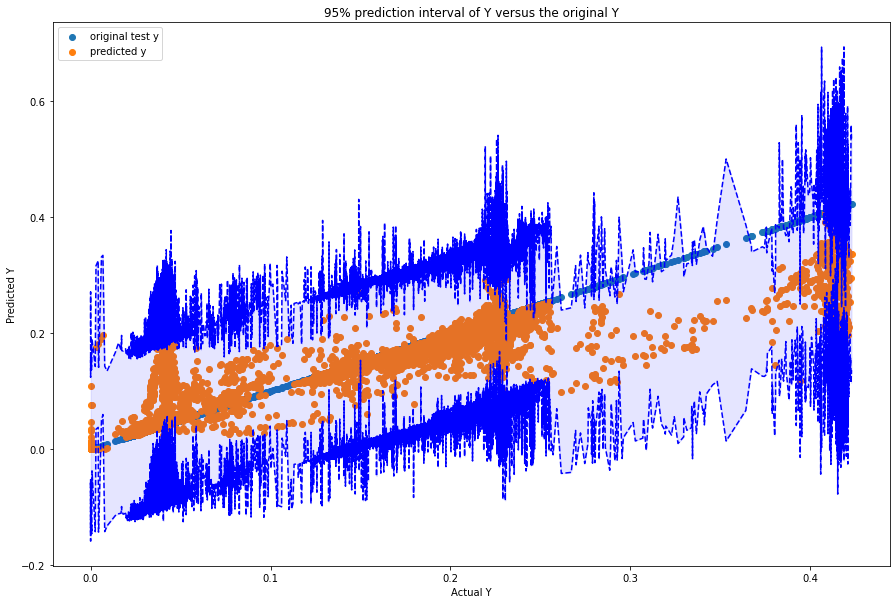

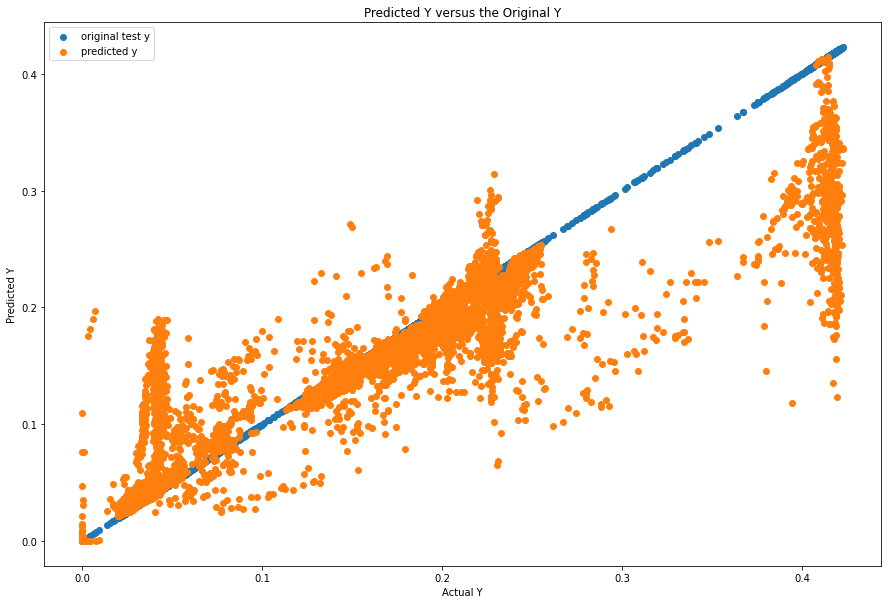

In [70]:
# ============== 1. Forestci
# calculate the variance
interval = fci.random_forest_error(regr, X_train,X_test)

# upper and lower
ylow = yhat - 1.96*np.sqrt(interval)
yup = yhat + 1.96*np.sqrt(interval)

plotci_1(Y_test, yhat, ylow, yup)

In [71]:
# ----- Export csv of TestDF (Coor and result)
print('[Saving] Save predicted test FOI with coords')
Coor = Test_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Actual = pd.Series(Y_test).values,
                   Predict = pd.Series(yhat).values,
                   Lower = pd.Series(ylow).values,
                   Upper = pd.Series(yup).values)
filename_test = 'Test_FOI_RF_forestci_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_test, sep='\t', encoding='utf-8')


[Saving] Save predicted test FOI with coords


In [68]:
def plotci_2(Y_test, yhat, ylow, yup, m_name, method):
    # dataframe
    dat = np.concatenate((Y_test.reshape(-1,1), 
                          yhat.reshape(-1,1), 
                          ylow.reshape(-1,1), 
                          yup.reshape(-1,1)),axis = 1)
    dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])

    # sort the dataframe for plotting
    dat2 = dat.sort_values('y')
    
    # take 1% and replot the above CI
    dat2 = dat2.sample(frac = 0.01, replace = False, random_state = 123)

    fig, ax = plt.subplots(figsize = (10,10))
    plt.scatter(dat2['y'], dat2['yhat'],label = 'Predicted test FOI')
    plt.plot([0.05,0.45],[0.05,0.45], 'k--')
    plt.errorbar(dat2['y'], dat2['yhat'], np.array(dat2['lower'], dat2['upper']), fmt='o')

    plt.xlabel('Actual FOI')
    plt.ylabel('Predicted FOI')
    plot_name = '95% interval of the predicted FOI versus the original FOI\n (1% of the test data)\n'+ m_name + ' - ' + method
    
    plt.title(plot_name)
    plt.legend()

    # Save thinned CI plot 
    print('[Saving] Save thinned CI plot')
    filename_ci_plot = 'CI_'+ m_name +'_' + method + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
    plt.savefig(Savepath + filename_ci_plot)

[Saving] Save thinned CI plot


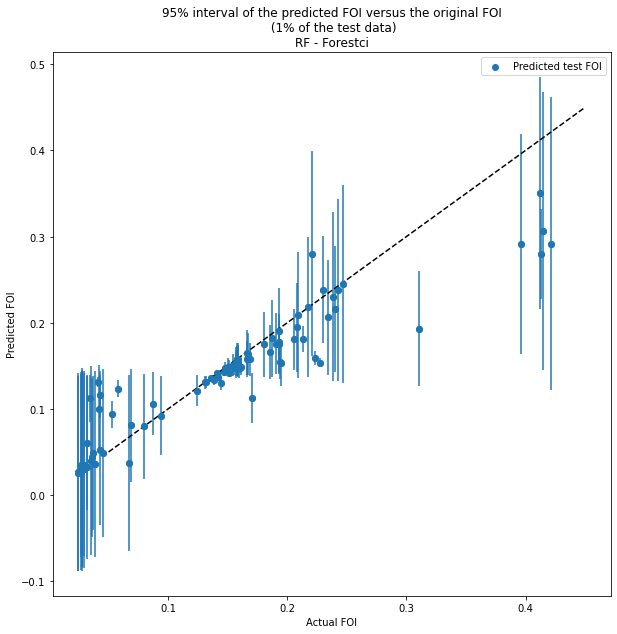

In [72]:
plotci_2(Y_test, yhat, ylow, yup, 'RF', 'Forestci')

#### Method 2: quantile regression

A general method for tree-based method is quantile regression. Random Forest gives the mean value of the response variables in each tree leaf in the forst. So instead of returning just the mean, we return all observed responses in the leaf, thus obtainining the conditional distribution $$P(Y ≤ y∣X=x)$$  of response values for every x. Then we take the 2.5 and 97.5 percentile of the distribution as our prediction interval. 

Quantile regression is very verstaile as it does not assume any conditional response distribution. However, it may lead to highly variable estimators. It is usually used as a benchmark when new methods come out. 


In [39]:
# ============== 2. Quantile regression 
def pred_ints(model, X, percentile = 95):
    print('[Predicting CI] Start predicting CI of FOI')
    start_time = time.time()
    err_down = []
    err_up = []
    for x in range(len(X)): #for each row of data
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.iloc[x,:].values.reshape(1,-1))[0])
        err_down.append(np.percentile(preds, (100-percentile)/2.))
        err_up.append(np.percentile(preds, 100-(100-percentile)/2.))
    end_time = time.time()
    print('[Predicting CI] Finish predicting CI of FOI')
    training_time = round(end_time - start_time, 5) # seconds
    print('Predicting Time: ' + str(training_time) + ' seconds')
    
    return err_down, err_up


In [40]:
err_down, err_up = pred_ints(regr, X_test, percentile = 95)
ylow = np.array(err_down)
yup = np.array(err_up)

[Predicting CI] Start predicting CI of FOI
[Predicting CI] Finish predicting CI of FOI
Predicting Time: 1556.77039 seconds


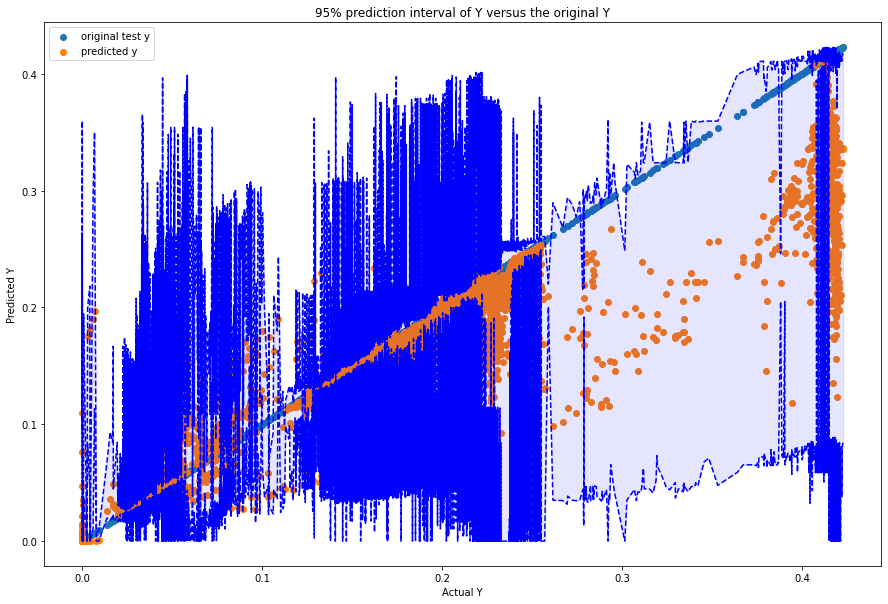

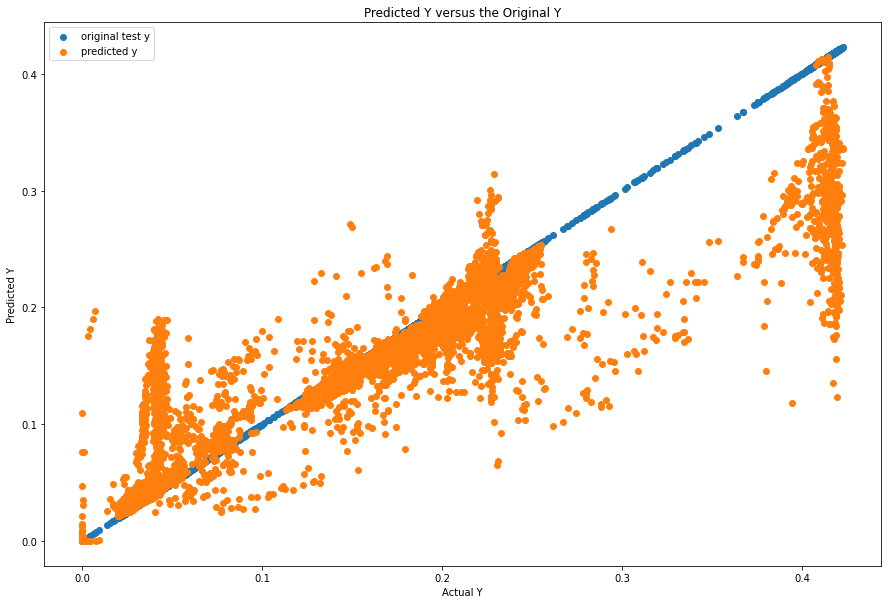

In [58]:
plotci_1(Y_test, yhat, ylow, yup)

Now we've obtained both the average predictions (Y_Predict_Train), as well as their 95% CI (err_down, err_up).

In [43]:
# ----- Export csv of TestDF (Coor and result)
print('[Saving] Save predicted test FOI with coords')
Coor = Test_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Actual = pd.Series(Y_test).values,
                   Predict = pd.Series(yhat).values,
                   Lower = pd.Series(ylow).values,
                   Upper = pd.Series(yup).values)
filename_test = 'Test_FOI_'+ m_name +'_quantile_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_test, sep='\t', encoding='utf-8')


[Saving] Save predicted test FOI with coords


This method gives a rather wide prediction interval, compared to what we can see from Gradient Boosting or XGBoost, or when comparing against the 'forestci' method above. 

[Saving] Save thinned CI plot


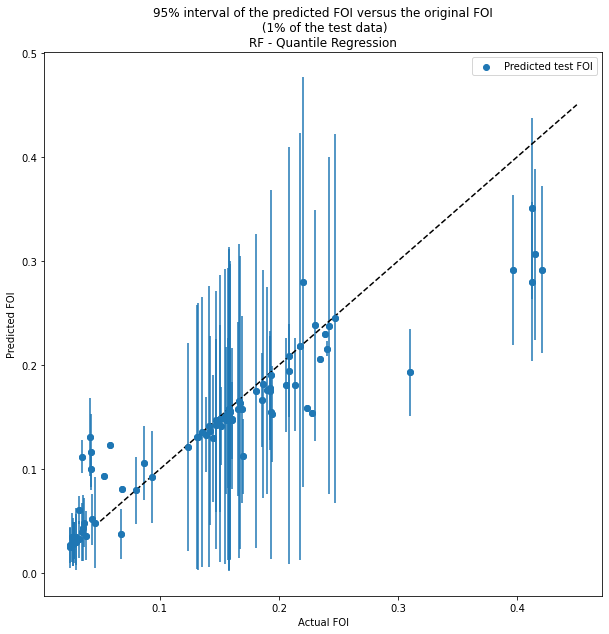

In [69]:
plotci_2(Y_test, yhat, ylow, yup, 'RF', 'Quantile Regression')

#### Predicting for the endemic data

In [81]:
# ============== 1. Forestci
Y_Predict_Endemic = regr.predict(X_endemic)
interval_endemic = fci.random_forest_error(regr, X_train,X_endemic)

# upper and lower
ylow_endemic = Y_Predict_Endemic - 1.96*np.sqrt(interval_endemic)
yup_endemic = Y_Predict_Endemic + 1.96*np.sqrt(interval_endemic)

In [82]:
# ----- Export csv of EndemicDF (Coor and result)
print('[Saving] Save predicted FOI with coords')
Coor = EndemicDF_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Predict = pd.Series(Y_Predict_Endemic).values,
                  Lower = ylow_endemic,
                  Upper = yup_endemic)
filename_endemic = 'Endemic_FOI_RF_Forestci_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_endemic, sep='\t', encoding='utf-8')


[Saving] Save predicted FOI with coords


In [83]:
# ============== 2. Quantile regression
err_down, err_up = pred_ints(regr, X_endemic, percentile = 95)
ylow_endemic = np.array(err_down)
yup_endemic = np.array(err_up)

[Predicting CI] Start predicting CI of FOI
[Predicting CI] Finish predicting CI of FOI
Predicting Time: 1752.80599 seconds


In [84]:
# ----- Export csv of EndemicDF (Coor and result)
print('[Saving] Save predicted FOI with coords')
Coor = EndemicDF_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Predict = pd.Series(Y_Predict_Endemic).values,
                  Lower = ylow_endemic,
                  Upper = yup_endemic)
filename_endemic = 'Endemic_FOI_RF_Quantile Regression_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_endemic, sep='\t', encoding='utf-8')


[Saving] Save predicted FOI with coords
